In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

#from glob import glob
from pathlib import Path
import os, time

import numpy as np

import xarray as xr
#from xorca.lib import load_xorca_dataset # not strictly necessary
#from xgcm import Grid

#from itidenatl.nemodez import Vmodes
import itidenatl.utils as ut

In [2]:
from dask.distributed import Client, LocalCluster
scratch = Path(os.getenv("SCRATCHDIR"))

cluster = LocalCluster(local_directory=scratch) #n_workers=24, threads_per_worker=1, memory_limit=8e6,silence_logs=50
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:34934 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 56 Memory: 236.33 GiB


In [3]:
### define paths
workdir = Path("/work/CT1/ige2071/nlahaye")
scratchdir = Path(str(scratch).replace(os.getenv("USER"),"nlahaye"))
worksha = (workdir/"../SHARED").resolve()

vmod_path = {"gen": worksha/"vmodes/vmodes_10.zarr", 
             "pres": worksha/"vmodes/vmodes_10.zarr",
             "u": worksha/"vmodes/phi_u_10.zarr",
             "v": worksha/"vmodes/phi_v_10.zarr"
            }          
#ssh_path = Path("/store/albert7a/eNATL60/zarr/eNATL60-BLBT02-SSH-1h") # zarr
grid_path = scratchdir/"mesh_mask_eNATL60_3.6.nc"


In [4]:
### dates and variables: will do all available if None is specified
# can use ut.get_dates_from_iday to get date from i_day (1, 2, 3, etc up to 440)
my_dates = "20090701"
my_vars = None # list or str with "pres", "u", "v", or None for all

In [2]:
### local utilitary routines

def get_modamp_path(var=None, date=None, path=None):
    """ get paths for modal projections. this should go in utils.
    WARNING: existence of files is not verified!
    Parameters
    __________
    var: str or list of str, optional
        variable name(s). None wil do all variables available
    date: str or list of str
        dates, format "yyyymmdd". None will do all available
    path: str or pathlib object, optional
        Path to modal projections. None will use default
    filename: str, optional
        name of files (can take 2 format arguments for var and date)
    
    Returns:
        dico with 
    """
    if path is None:
        path = Path("/work/CT1/ige2071/SHARED/modal_proj")
    filename = "{}_global_{}.zarr" # .format(var, date)
    if var is None:
        var = [p.name for p in path.glob("*") if p.is_dir()]
    elif isinstance(var, list):
        var = ["modamp_"+v.replace("modamp_","") for v in var]
    elif isinstance(var, str) and not var.startswith("modamp_"):
        var = ["modamp_"+var]
    if date is None:
        dico = {v.replace("modamp_",""):
                list(np.sort(np.array( list( (path/v).glob(filename.format(v, "*")) )
                                     ))) for v in var
               }
    elif isinstance(date, str):
        dico = {v.replace("modamp_",""):[path/v/filename.format(v, date)] for v in var}
    else:
        dico = {v.replace("modamp_",""):[path/v/filename.format(v, d) for d in date] for v in var}
    return dico

### routine for preparing plots
plot_kwgs = {"figsize":(12,8),
                 "central_lon":-50, "extent":[-97, 0, 6, 58]
                }               
                 
def prep_one_plot(**kwargs):
    kwgs = plot_kwgs.copy()
    kwgs.update(kwargs)
    map_proj = ccrs.Robinson(central_longitude=kwgs["central_lon"])

    fig = plt.figure(figsize=kwgs["figsize"])
    ax = plt.axes(projection=map_proj)
    gl = ax.gridlines(draw_labels=True)
    ax.add_feature(cfeature.LAND, facecolor="lightgray")
    ax.set_extent(kwgs["extent"])
    return fig, ax
                     

In [97]:
### load data
data_path = get_modamp_path(var=my_vars, date=my_dates)
ds = xr.Dataset()
for k,v in data_path.items():
    ds = ds.merge(xr.open_mfdataset(v, concat_dim="t", combine="nested", engine="zarr"), join="inner")
ds
chks = {k[0]:v[0] for k,v in ds.chunks.items() if k in ["x_c", "y_c"]}

### add lon, lat coords
for c in ["llon_cc", "llat_cc"]:
    if c in ds.coords:
        ds[c] = ut.open_one_coord(grid_path, chunks=chks, varname=c)[c]
    else:
        ds = ds.assign_coords({c:ut.open_one_coord(grid_path, chunks=chks, varname=c)[c]})
ds

### add a mask, from mode file
dm = xr.open_zarr(vmod_path["gen"]).chunk({k+"_c":chks[k] for k in ["x","y"]})
mask = (~xr.ufuncs.isnan(dm.norm.isel(mode=0)).reset_coords(drop=True)).persist()
ds = ds.assign_coords(mask=mask)

ds

<xarray.Dataset>
Dimensions:   (mode: 11, t: 24, x_c: 8354, x_r: 8354, y_c: 4729, y_r: 4729)
Coordinates:
  * mode      (mode) int64 0 1 2 3 4 5 6 7 8 9 10
  * t         (t) datetime64[ns] 2009-07-01T00:30:00 ... 2009-07-01T23:30:00
  * x_c       (x_c) int64 1 2 3 4 5 6 7 8 ... 8348 8349 8350 8351 8352 8353 8354
  * y_c       (y_c) int64 1 2 3 4 5 6 7 8 ... 4723 4724 4725 4726 4727 4728 4729
  * x_r       (x_r) float32 1.5 2.5 3.5 4.5 ... 8.352e+03 8.354e+03 8.354e+03
  * y_r       (y_r) float32 1.5 2.5 3.5 4.5 ... 4.728e+03 4.728e+03 4.73e+03
    llon_cc   (y_c, x_c) float32 dask.array<chunksize=(400, 8354), meta=np.ndarray>
    llat_cc   (y_c, x_c) float32 dask.array<chunksize=(400, 8354), meta=np.ndarray>
    mask      (y_c, x_c) bool dask.array<chunksize=(400, 8354), meta=np.ndarray>
Data variables:
    pres      (y_c, x_c, t, mode) float32 dask.array<chunksize=(400, 8354, 24, 1), meta=np.ndarray>
    vozocrtx  (t, y_c, x_r, mode) float32 dask.array<chunksize=(24, 400, 8354, 1), meta=np.ndarray>
    vomecrty  (t, y_r, x_c, mode) float32 dask.array<chunksize=(24, 400, 8354, 1), meta=np.ndarray>

In [95]:
### exemple of plot: anomaly in time w.r.t time mean
it, imod = 12, 1
pmod_moy = ds.pres.sel(mode=imod).mean("t")
toplot = (ds.pres.isel(t=it).sel(mode=imod)-pmod_moy).persist().squeeze()

/scratch/cnt0024/ige2071/nlahaye/conda/conda38/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


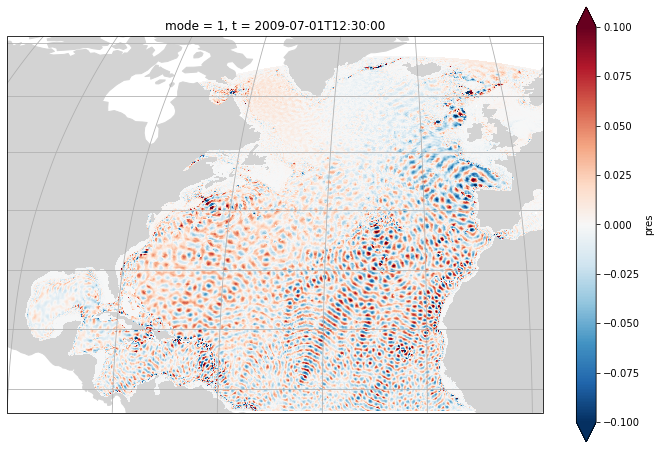

In [96]:
norm = mpl.colors.Normalize(vmin=-.1, vmax=.1)
cmap = "RdBu_r"

fig, ax = prep_one_plot()
p = toplot.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), 
                                     x="llon_cc", y="llat_cc", 
                                    norm=norm, cmap=cmap)